In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                 'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                 'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                 'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                 '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                  "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                  'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                  'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                  '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl', 'wdw','disneylandparis',
                  'theme_park', 'min', 'day', 'new', 'guy', 'year', 'way', 'part', 'thing', 'man','ティスニー',
                  'side', 'sia', 'ティスニーラント', 'ティスニーハロウィーン', 'today', 'wanna', 'place',
                  'world', 'disneyworld', 'next', 'disneypark', '東京ティスニーシー', 'yen',
                  '東京ティスニーラント', 'land', 'park', 'ティスニーシー', 'tdl', 'tdrmd', 'lot',
                  "東京ティスニーリソート"])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
df = pd.read_json('DiSmldata.json')

In [3]:
df_ja_pos = df[(df['label'] == 2)]

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_ja_pos.clean_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['new', 'mickey', 'flower', 'bed', 'going', 'make', 'event', 'photo', 'location', 'world', 'bazaar', 'side', 'there', 'space', 'mickey', 'side', 'put', 'photo', 'location', 'tdrnow', 'sia']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # higher threshold fewer phrases. Must show up more than 2 times the phrases 
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [6]:
data_ready[0:10]

[['go',
  'make',
  'event',
  'photo_location',
  'bazaar',
  'space',
  'mickey',
  'put',
  'photo_location'],
 ['hihi_jet',
  'yusuke',
  'takahashi',
  'dribo',
  'best',
  'rest',
  'performance',
  'tell',
  'thank',
  'respond',
  'smile',
  'seem',
  'friend',
  'together'],
 ['cushion', 'discontinue'],
 ['want',
  'arrive',
  'grandfather',
  'love',
  'take_picture',
  'guest',
  'dressed_costume',
  'person',
  'take',
  'grandfather',
  'inseptember',
  'hear',
  'halloween',
  'time',
  'people',
  'talk',
  'gather',
  'grandfather',
  'know'],
 ['ride', 'attraction', 'play', 'hour'],
 ['choreography', 'time', 'party_gras', 'ミッキー', 'mickey', 'disneyphoto'],
 ['entrance', 'right', 'detour', 'leave', 'also', 'revive', 'tdrnowd'],
 ['showbased',
  'sweetheart',
  'cafe',
  'bread',
  'sell',
  'cast',
  'say',
  'start',
  'type'],
 ['get',
  'snack',
  'goondli',
  'mood',
  'gondrie_snack',
  'grand',
  'menu',
  'introduce'],
 ['ento', 'middle', 'release', 'left_right', 

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [8]:
#3 Topics
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [9]:
pprint(lda_model3.print_topics())

[(0,
  '0.020*"time" + 0.015*"go" + 0.014*"first" + 0.011*"think" + 0.011*"fun" + '
  '0.010*"daughter" + 0.009*"even" + 0.009*"people" + 0.009*"nice" + '
  '0.009*"family"'),
 (1,
  '0.058*"want" + 0.033*"good" + 0.030*"cute" + 0.028*"halloween" + '
  '0.013*"see" + 0.013*"happy" + 0.009*"buy" + 0.009*"mickey" + 0.009*"love" + '
  '0.008*"tdrfood"'),
 (2,
  '0.021*"christmas" + 0.016*"sea" + 0.016*"also" + 0.015*"come" + '
  '0.014*"resort" + 0.011*"take" + 0.008*"person" + 0.008*"sale_advance" + '
  '0.008*"thank" + 0.007*"enjoy"')]


In [10]:
#4 Topics
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [11]:
pprint(lda_model4.print_topics())

[(0,
  '0.029*"time" + 0.022*"go" + 0.021*"first" + 0.016*"fun" + 0.015*"mickey" + '
  '0.014*"even" + 0.013*"great" + 0.013*"nice" + 0.013*"family" + 0.011*"say"'),
 (1,
  '0.067*"want" + 0.038*"good" + 0.034*"cute" + 0.032*"halloween" + '
  '0.022*"christmas" + 0.015*"see" + 0.015*"happy" + 0.010*"love" + '
  '0.010*"tdrfood" + 0.010*"much"'),
 (2,
  '0.022*"also" + 0.021*"come" + 0.012*"line" + 0.011*"person" + 0.011*"thank" '
  '+ 0.010*"understand" + 0.010*"lol" + 0.010*"end" + 0.009*"free" + '
  '0.009*"open"'),
 (3,
  '0.023*"sea" + 0.020*"resort" + 0.016*"think" + 0.015*"take" + 0.015*"buy" + '
  '0.014*"daughter" + 0.013*"people" + 0.011*"sale_advance" + 0.011*"know" + '
  '0.009*"enjoy"')]


In [12]:
#5 Topics
lda_model5 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [13]:
pprint(lda_model5.print_topics())

[(0,
  '0.038*"time" + 0.027*"first" + 0.021*"fun" + 0.018*"even" + 0.017*"family" '
  '+ 0.013*"show" + 0.013*"little" + 0.013*"free" + 0.011*"make" + '
  '0.011*"oneman"'),
 (1,
  '0.082*"want" + 0.046*"good" + 0.042*"cute" + 0.039*"halloween" + '
  '0.027*"christmas" + 0.012*"tdrfood" + 0.012*"much" + 0.011*"sale" + '
  '0.010*"laugh" + 0.009*"end"'),
 (2,
  '0.027*"also" + 0.019*"take" + 0.017*"love" + 0.015*"people" + 0.015*"line" '
  '+ 0.014*"person" + 0.013*"know" + 0.013*"understand" + 0.011*"various" + '
  '0.009*"row"'),
 (3,
  '0.032*"sea" + 0.031*"come" + 0.028*"resort" + 0.020*"daughter" + '
  '0.016*"sale_advance" + 0.013*"enjoy" + 0.013*"get" + 0.013*"open" + '
  '0.011*"lottery" + 0.011*"beautiful"'),
 (4,
  '0.025*"see" + 0.025*"go" + 0.024*"happy" + 0.019*"think" + 0.018*"buy" + '
  '0.017*"mickey" + 0.015*"great" + 0.015*"nice" + 0.014*"photo" + '
  '0.014*"mean"')]


In [14]:
#6 Topics
lda_model6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [15]:
pprint(lda_model6.print_topics())

[(0,
  '0.033*"go" + 0.031*"first" + 0.025*"fun" + 0.021*"even" + 0.020*"great" + '
  '0.020*"family" + 0.017*"understand" + 0.014*"drink" + 0.013*"make" + '
  '0.012*"price"'),
 (1,
  '0.071*"good" + 0.041*"christmas" + 0.029*"come" + 0.019*"daughter" + '
  '0.016*"line" + 0.016*"person" + 0.016*"laugh" + 0.015*"thank" + 0.014*"lol" '
  '+ 0.014*"end"'),
 (2,
  '0.111*"want" + 0.053*"halloween" + 0.027*"also" + 0.024*"happy" + '
  '0.018*"take" + 0.017*"love" + 0.016*"tdrfood" + 0.015*"people" + '
  '0.014*"photo" + 0.012*"child"'),
 (3,
  '0.077*"cute" + 0.026*"think" + 0.021*"much" + 0.019*"sale" + 0.015*"little" '
  '+ 0.015*"get" + 0.014*"case" + 0.013*"lottery" + 0.012*"souvenir" + '
  '0.011*"store"'),
 (4,
  '0.037*"see" + 0.026*"buy" + 0.022*"nice" + 0.020*"mean" + 0.018*"hope" + '
  '0.018*"seem" + 0.017*"dream" + 0.016*"friend" + 0.014*"donald" + '
  '0.014*"eat"'),
 (5,
  '0.042*"time" + 0.034*"sea" + 0.030*"resort" + 0.022*"mickey" + '
  '0.017*"sale_advance" + 0.016*"say"

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, corpus, dictionary=lda_model3.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.130680  0.208965       1        1  34.519341
1     -0.259375  0.001069       2        1  33.702599
2      0.128695 -0.210034       3        1  31.778055, topic_info=     Category         Freq       Term        Total  loglift  logprob
40    Default  1507.000000       want  1507.000000  30.0000  30.0000
103   Default   848.000000       good   848.000000  29.0000  29.0000
85    Default   769.000000       cute   769.000000  28.0000  28.0000
29    Default   723.000000  halloween   723.000000  27.0000  27.0000
178   Default   513.000000  christmas   513.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
1464   Topic3   101.056801     minute   102.001755   1.1371  -5.4891
1747   Topic3    99.198540     window   100.178070   1.1366  -5.5076
1236   Topic3   107.733559       shop   108.981522   1.1349  -5.4251
52     Topic3   100.776321      leave   102.038109   1.1340  -5.4919
1405   Topic3   104.567520   campaign   109.643135   1.0990  -5.4549

[135 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
49        3  0.996778       also
401       3  0.997139       back
135       3  0.996532  beautiful
152       3  0.989608     become
1546      1  0.992889        big
...     ...       ...        ...
643       1  0.009594        www
643       2  0.988186        www
1222      2  0.007978  yesterday
1222      3  0.989313  yesterday
2208      2  0.997871      ハロウィン

[139 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [17]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model6, corpus, dictionary=lda_model6.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.137213  0.143405       1        1  18.400515
5     -0.163103  0.106266       2        1  18.229809
2      0.298758  0.158435       3        1  17.323086
0      0.065577 -0.235626       4        1  16.558544
4     -0.027087 -0.126247       5        1  14.783852
3     -0.036932 -0.046233       6        1  14.704199, topic_info=     Category         Freq        Term        Total  loglift  logprob
40    Default  1474.000000        want  1474.000000  30.0000  30.0000
103   Default  1001.000000        good  1001.000000  29.0000  29.0000
85    Default   866.000000        cute   866.000000  28.0000  28.0000
29    Default   707.000000   halloween   707.000000  27.0000  27.0000
39    Default   590.000000        time   590.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
2180   Topic6    50.348507        long    51.221104   1.8999  -5.4152
166    Topic6    54.579269        size    55.549370   1.8994  -5.3345
7414   Topic6    70.867119       trash    72.451584   1.8949  -5.0733
562    Topic6    58.541134       https    60.579708   1.8828  -5.2644
4984   Topic6    56.263283  paos_lunch    62.690323   1.8089  -5.3041

[223 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
294       3  0.991273       able
49        3  0.996225       also
207       5  0.991190    amazing
127       3  0.992420       area
401       5  0.987777       back
...     ...       ...        ...
400       6  0.991487  wonderful
372       2  0.991536       work
643       5  0.996117        www
1222      1  0.992692  yesterday
2208      4  0.996293      ハロウィン

[213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 1, 5, 4])

In [18]:
#10 Topics
lda_model10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [19]:
pprint(lda_model10.print_topics())

[(0,
  '0.000*"cute_chick" + 0.000*"mofumov" + 0.000*"product_pin" + '
  '0.000*"efficient" + 0.000*"disney写真" + 0.000*"夢か叶う場所" + 0.000*"disneysee" + '
  '0.000*"gucci" + 0.000*"ill_best" + 0.000*"bir"'),
 (1,
  '0.110*"want" + 0.062*"good" + 0.056*"cute" + 0.053*"halloween" + '
  '0.036*"christmas" + 0.033*"time" + 0.018*"buy" + 0.016*"tdrfood" + '
  '0.016*"much" + 0.014*"sale"'),
 (2,
  '0.034*"happy" + 0.027*"take" + 0.025*"love" + 0.023*"even" + 0.022*"people" '
  '+ 0.020*"photo" + 0.020*"mean" + 0.020*"person" + 0.019*"know" + '
  '0.018*"hope"'),
 (3,
  '0.000*"cute_chick" + 0.000*"mofumov" + 0.000*"product_pin" + '
  '0.000*"efficient" + 0.000*"disney写真" + 0.000*"夢か叶う場所" + 0.000*"disneysee" + '
  '0.000*"gucci" + 0.000*"ill_best" + 0.000*"bir"'),
 (4,
  '0.035*"resort" + 0.034*"first" + 0.028*"think" + 0.022*"family" + '
  '0.021*"line" + 0.019*"say" + 0.017*"free" + 0.016*"look" + 0.014*"lottery" '
  '+ 0.014*"row"'),
 (5,
  '0.041*"fun" + 0.034*"nice" + 0.030*"thank" + 0.028

In [22]:
# import pyLDAvis.gensim
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model10, corpus, dictionary=lda_model10.id2word)
# vis

In [ ]:
#5 topics seems to give the most coherent results

In [23]:
#Final Model

#5 Topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5155,"time, go, first, fun, mickey, daughter, tdrfoo...","[go, make, event, photo_location, bazaar, spac..."
1,1,4.0,0.4965,"nice, family, photo, thank, say, lol, seem, dr...","[hihi_jet, yusuke, takahashi, dribo, best, res..."
2,2,0.0,0.7251,"time, go, first, fun, mickey, daughter, tdrfoo...","[cushion, discontinue]"
3,3,2.0,0.8075,"want, good, halloween, also, happy, take, see,...","[want, arrive, grandfather, love, take_picture..."
4,4,1.0,0.4403,"cute, sea, resort, think, much, sale, laugh, s...","[ride, attraction, play, hour]"
5,5,0.0,0.5489,"time, go, first, fun, mickey, daughter, tdrfoo...","[choreography, time, party_gras, ミッキー, mickey,..."
6,6,2.0,0.4640,"want, good, halloween, also, happy, take, see,...","[entrance, right, detour, leave, also, revive,..."
7,7,0.0,0.4203,"time, go, first, fun, mickey, daughter, tdrfoo...","[showbased, sweetheart, cafe, bread, sell, cas..."
8,8,3.0,0.6079,"christmas, come, line, mean, end, little, free...","[get, snack, goondli, mood, gondrie_snack, gra..."
9,9,2.0,0.5310,"want, good, halloween, also, happy, take, see,...","[ento, middle, release, left_right, block]"


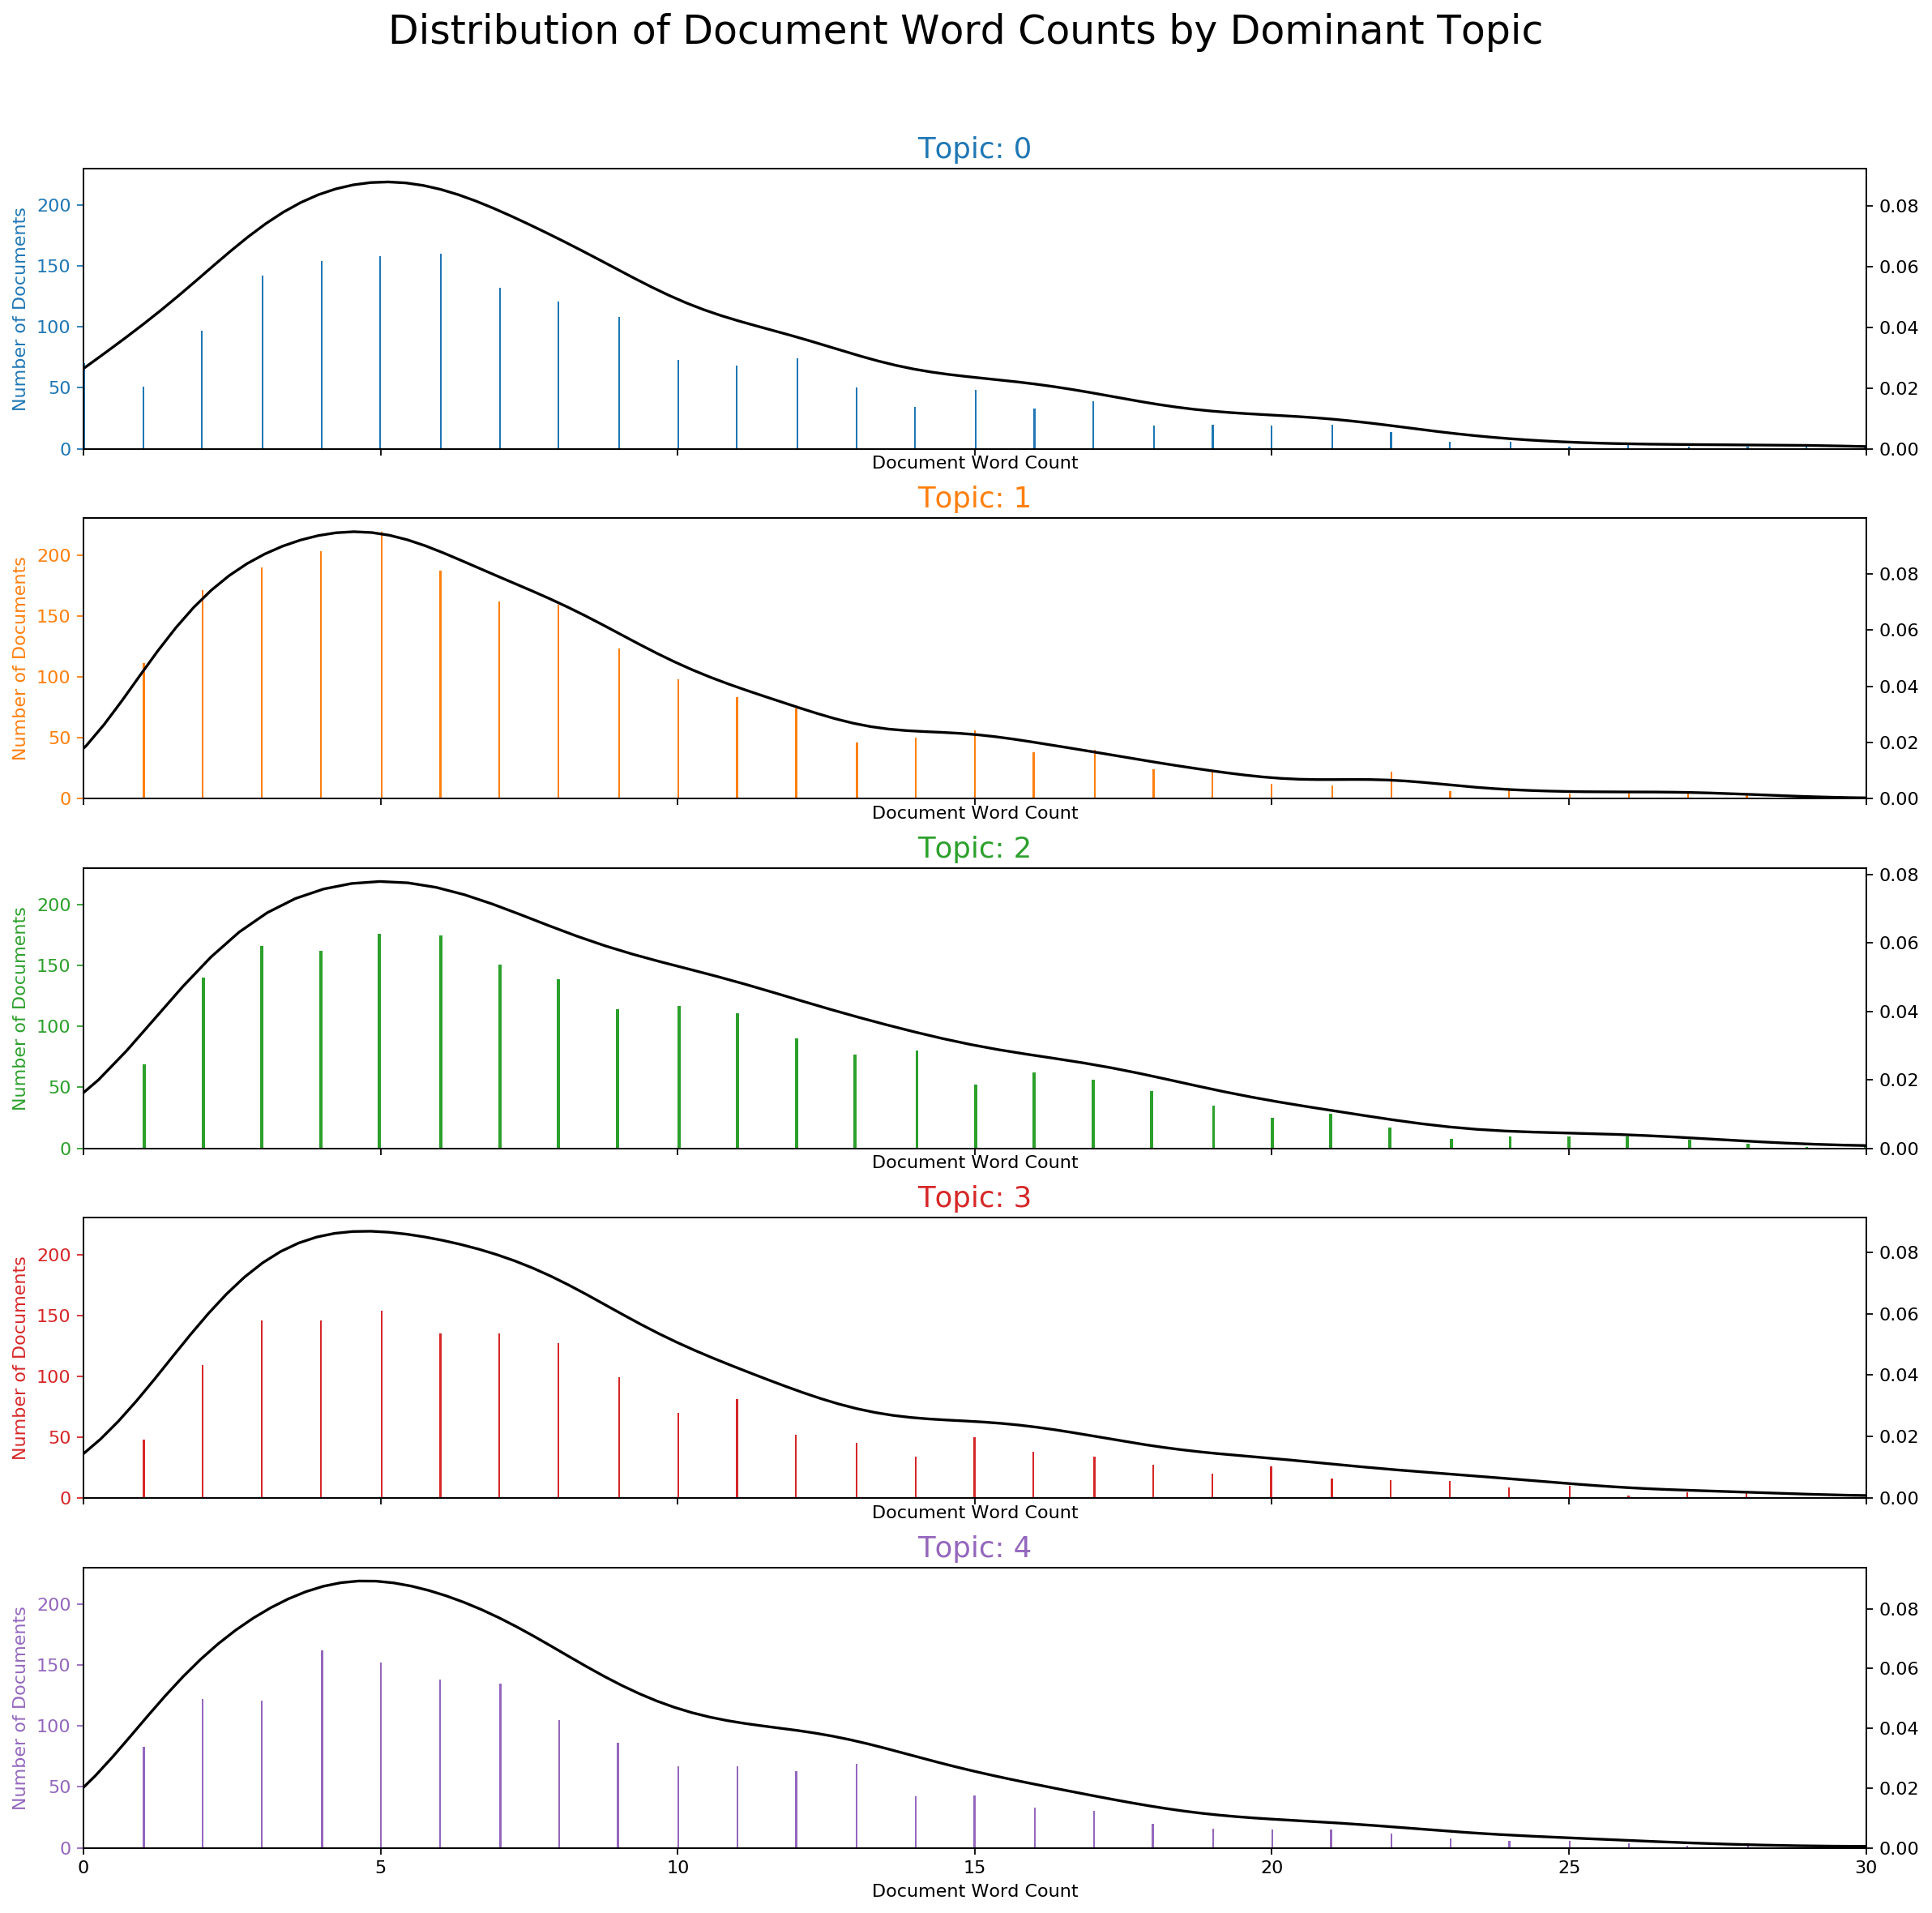

In [25]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,1,figsize=(15,15), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

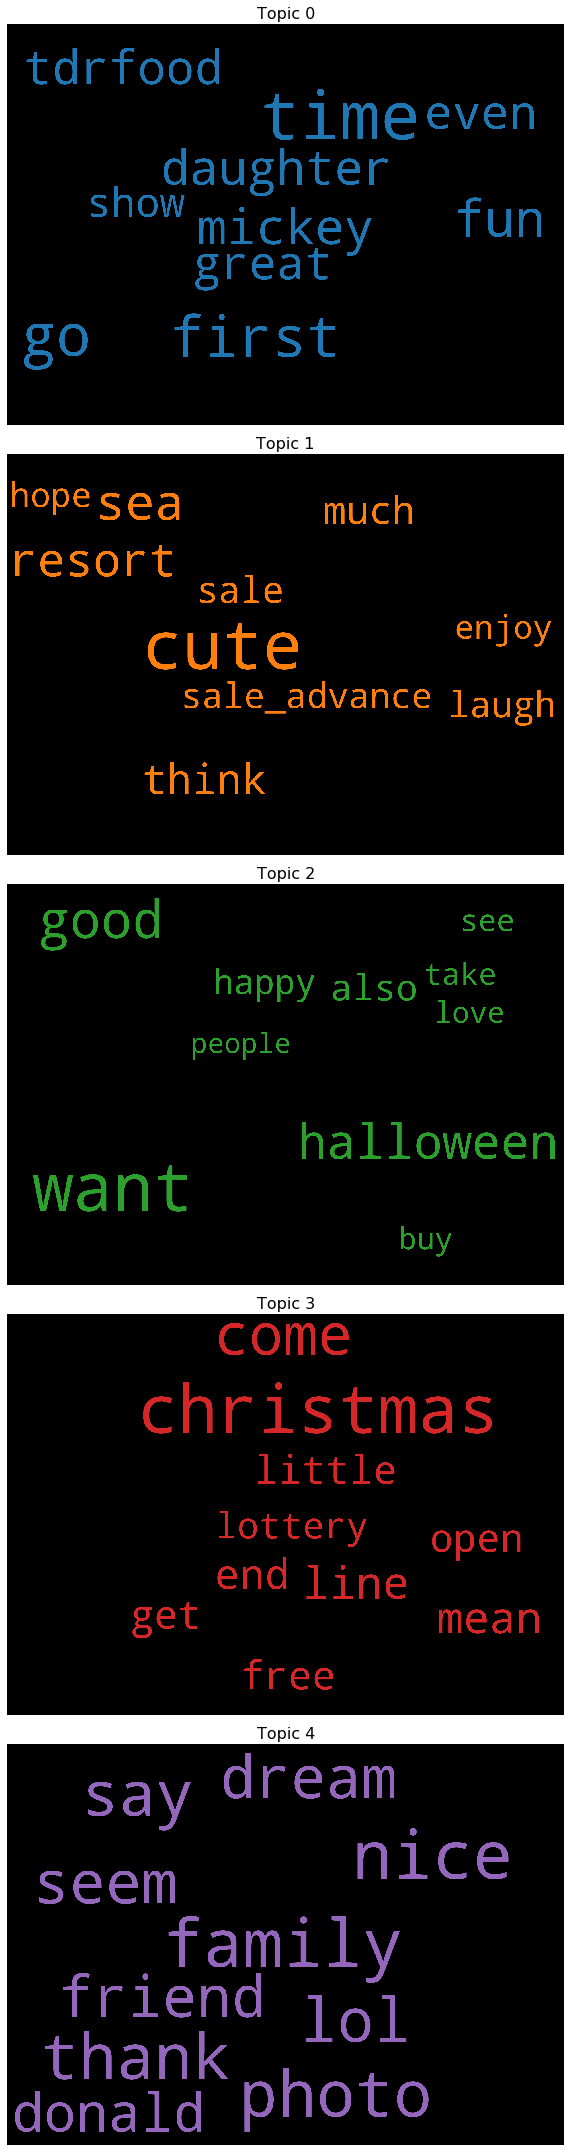

In [26]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

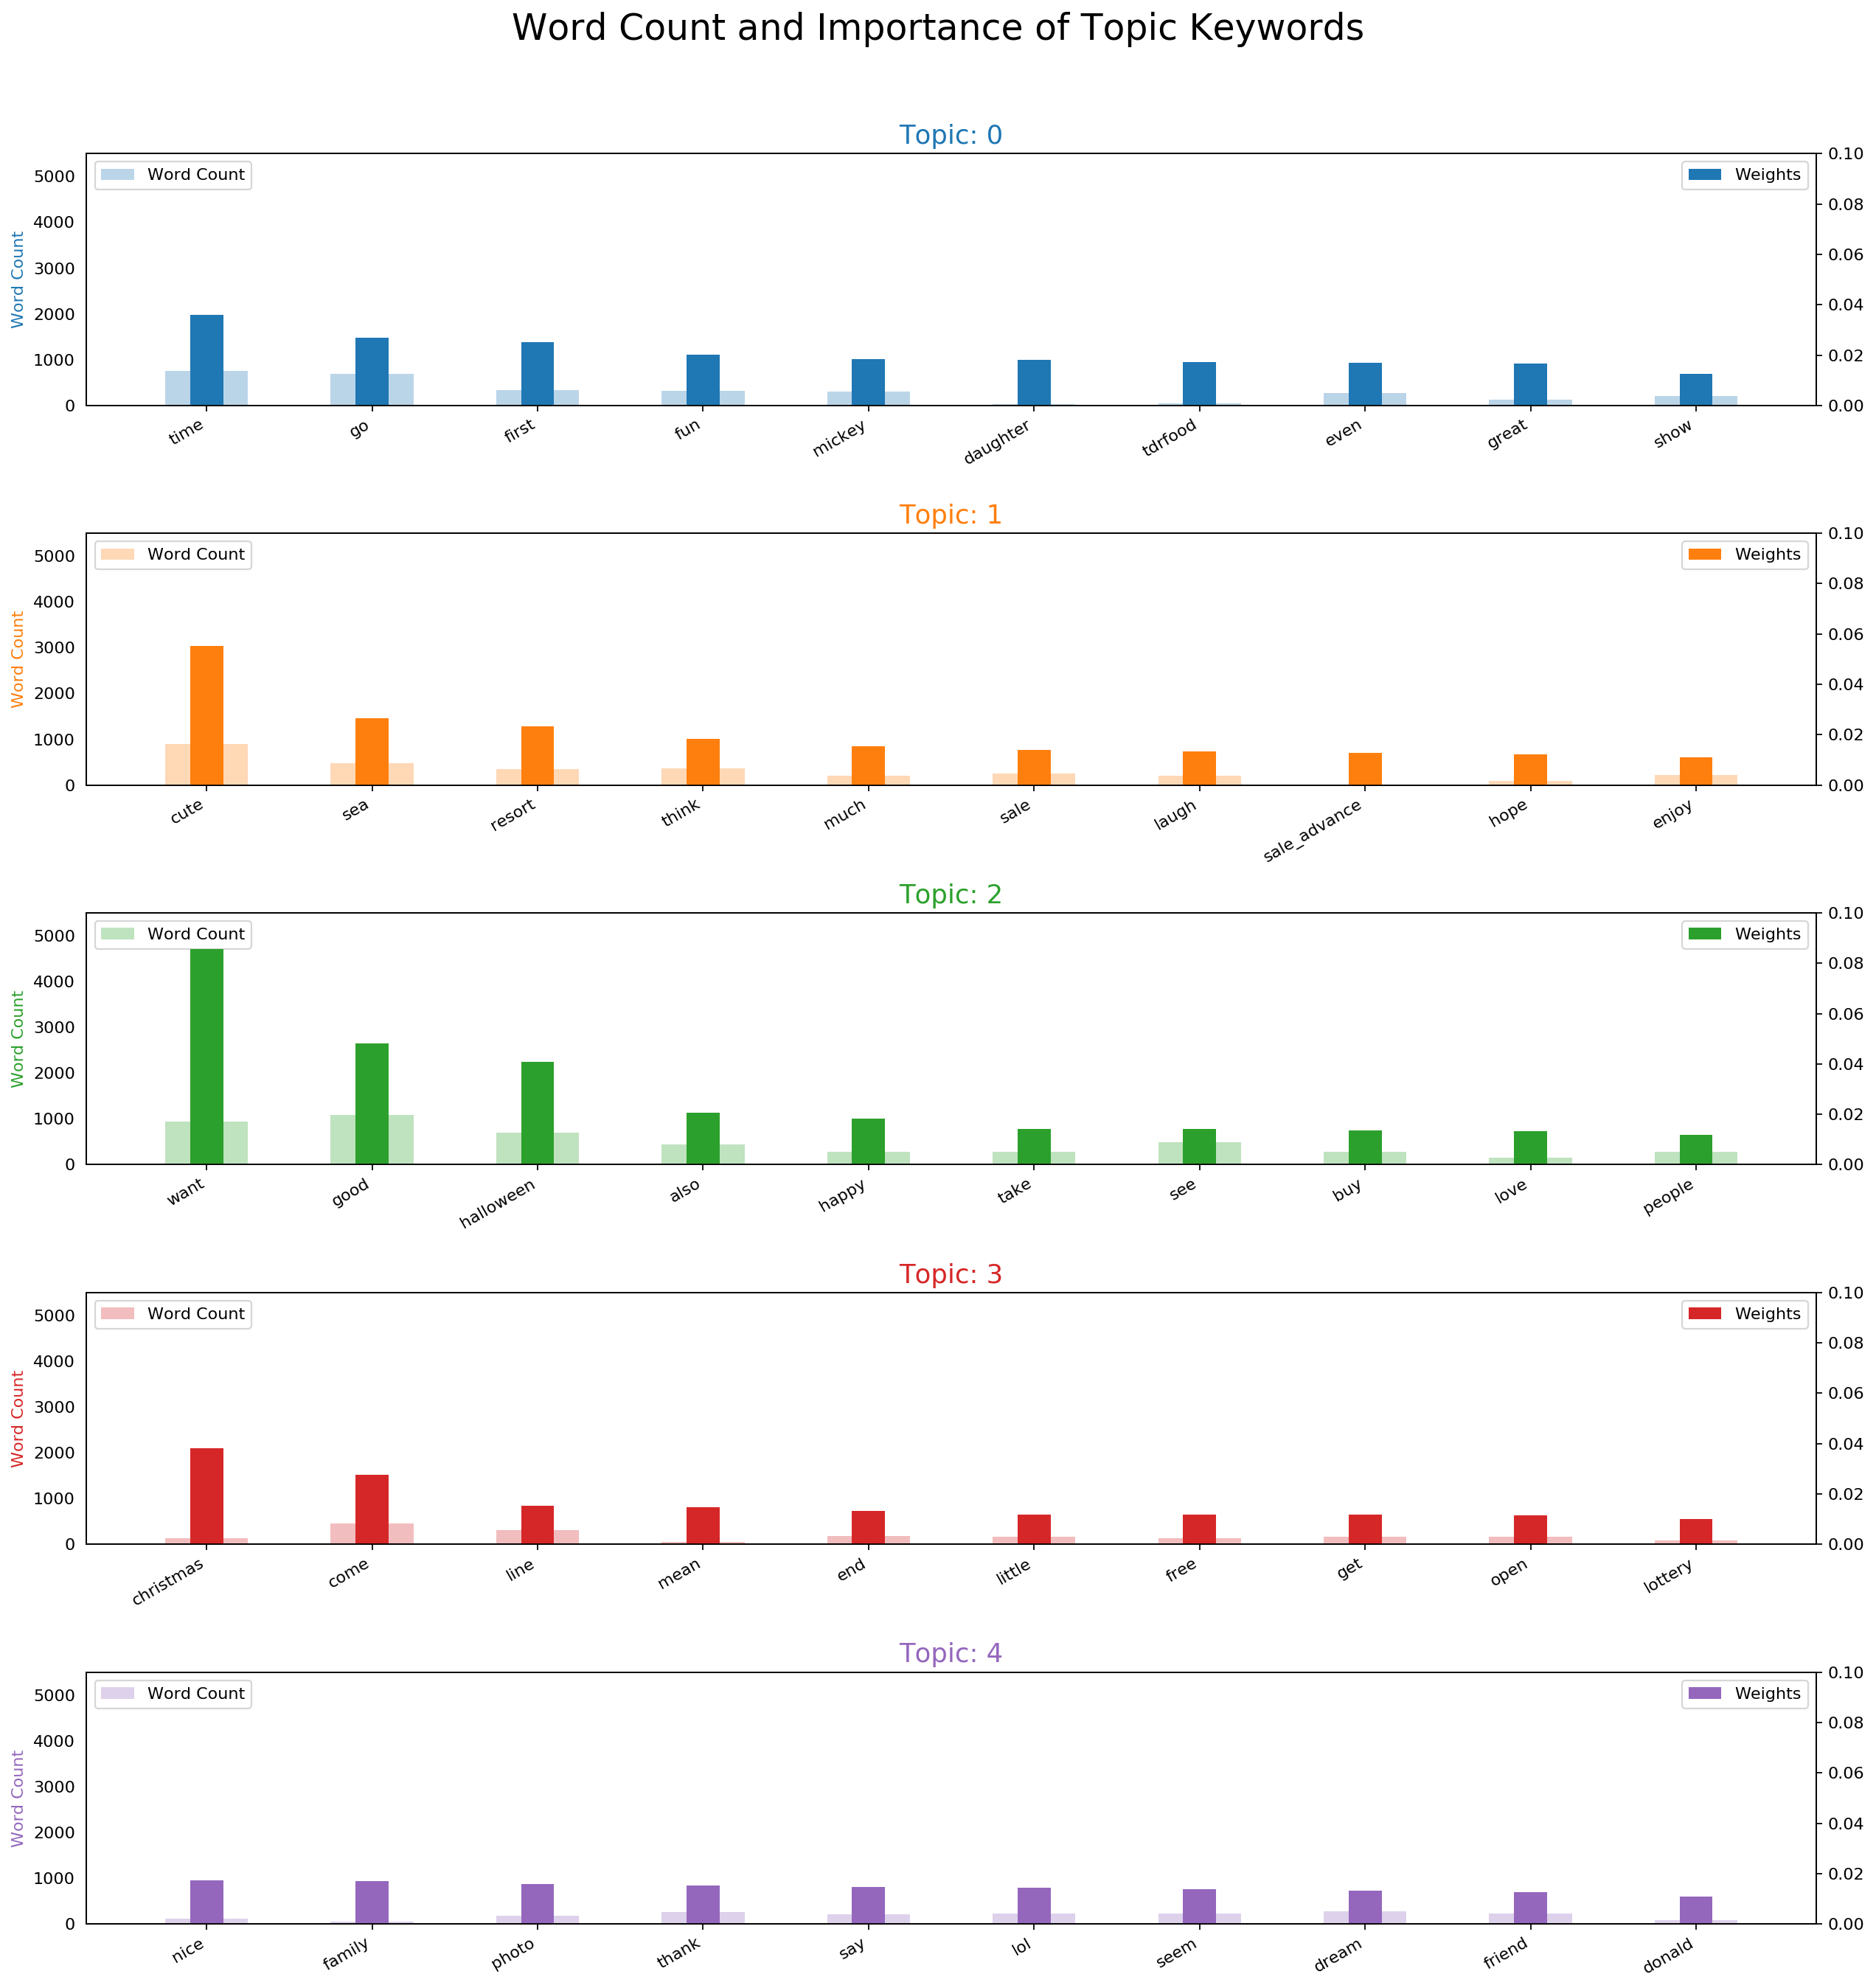

In [27]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 1, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 5500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [28]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

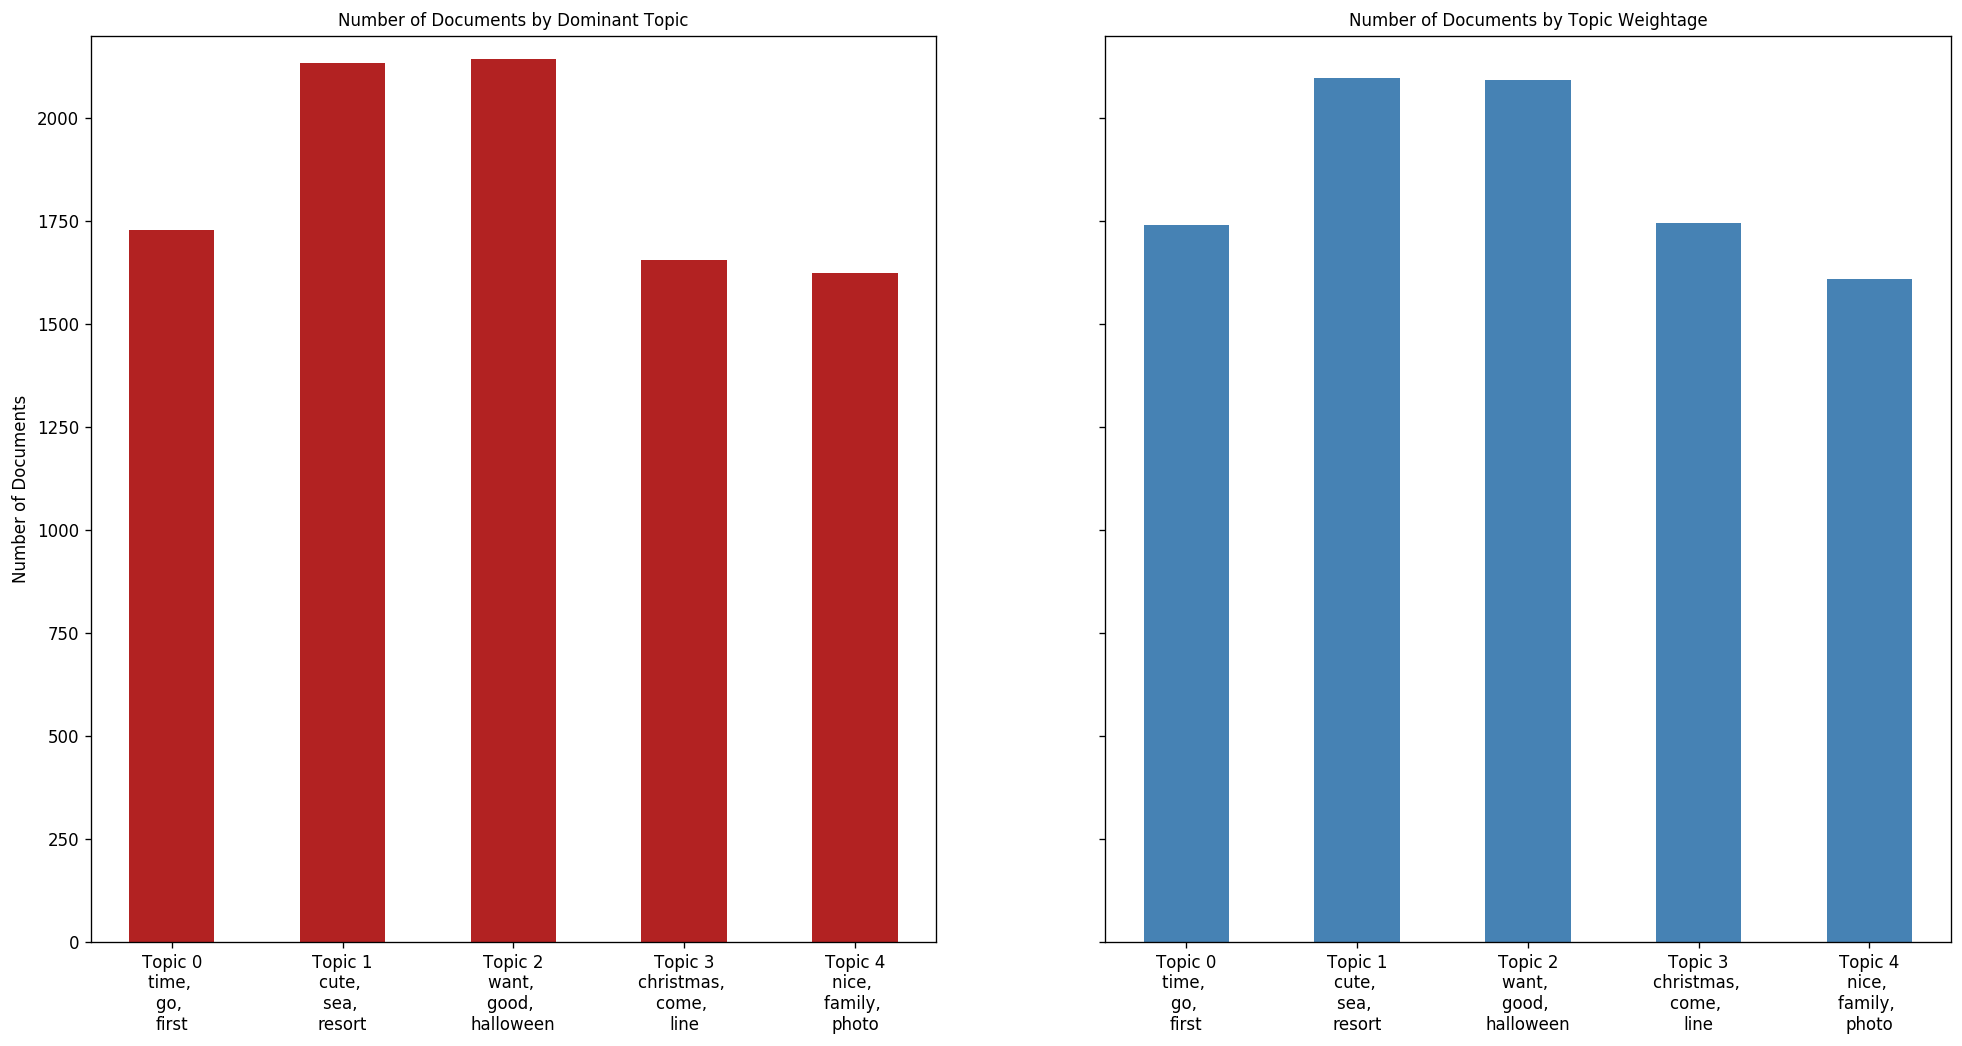

In [29]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [30]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state= 77, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7819 samples in 0.002s...
[t-SNE] Computed neighbors for 7819 samples in 0.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7819
[t-SNE] Computed conditional probabilities for sample 2000 / 7819
[t-SNE] Computed conditional probabilities for sample 3000 / 7819
[t-SNE] Computed conditional probabilities for sample 4000 / 7819
[t-SNE] Computed conditional probabilities for sample 5000 / 7819
[t-SNE] Computed conditional probabilities for sample 6000 / 7819
[t-SNE] Computed conditional probabilities for sample 7000 / 7819
[t-SNE] Computed conditional probabilities for sample 7819 / 7819
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.174599
[t-SNE] KL divergence after 1000 iterations: 0.829173


In [31]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [32]:
num_topics = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

time                 0.036
go                   0.027
first                0.025
fun                  0.020
mickey               0.019
daughter             0.018
tdrfood              0.017
even                 0.017
great                0.017
show                 0.012
Topic 1 |---------------------

cute                 0.055
sea                  0.026
resort               0.023
think                0.018
much                 0.015
sale                 0.014
laugh                0.013
sale_advance         0.013
hope                 0.012
enjoy                0.011
Topic 2 |---------------------

want                 0.086
good                 0.048
halloween            0.041
also                 0.021
happy                0.018
take                 0.014
see                  0.014
buy                  0.014
love                 0.013
people               0.012
Topic 3 |---------------------

christmas            0.038
com

In [33]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700,tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave")
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

Loading BokehJS ...

In [34]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.318726 -0.027197       1        1  23.402262
1     -0.099033 -0.233258       2        1  21.451653
0     -0.052282  0.207197       3        1  18.840370
3     -0.079152  0.120912       4        1  18.768188
4     -0.088258 -0.067654       5        1  17.537523, topic_info=     Category         Freq        Term        Total  loglift  logprob
40    Default  1541.000000        want  1541.000000  30.0000  30.0000
85    Default   913.000000        cute   913.000000  29.0000  29.0000
103   Default   867.000000        good   867.000000  28.0000  28.0000
29    Default   739.000000   halloween   739.000000  27.0000  27.0000
178   Default   552.000000   christmas   552.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
277    Topic5    68.854477       front    69.646866   1.7294  -5.2783
3012   Topic5    68.439209  strawberry    69.251068   1.7290  -5.2844
895    Topic5    77.129807        hair    78.081512   1.7286  -5.1648
1599   Topic5   132.971451         jal   150.015717   1.6202  -4.6202
1643   Topic5    76.742920      chance   100.528320   1.4708  -5.1699

[196 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
294       1  0.994468       able
49        1  0.998942       also
207       3  0.991563    amazing
401       1  0.984359       back
500       4  0.987195        bag
...     ...       ...        ...
400       4  0.990366  wonderful
372       2  0.991076       work
643       5  0.996024        www
1222      4  0.994589  yesterday
2208      1  0.987536      ハロウィン

[184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5])